# Continuing work after baseline was implemented
You can find baseline code in my other notebook called NeurIPS Ariel Baseline

# Analyze FSG data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fgs_path = '/kaggle/input/ariel-data-challenge-2025/train/1010375142/FGS1_signal_0.parquet'
fgs_data = pd.read_parquet(fgs_path)
print("FGS shape:", fgs_data.shape)
print("FGS columns:", fgs_data.columns if hasattr(fgs_data, 'columns') else 'Raw array')

FGS shape: (135000, 1024)
FGS columns: Index(['column_0', 'column_1', 'column_2', 'column_3', 'column_4', 'column_5',
       'column_6', 'column_7', 'column_8', 'column_9',
       ...
       'column_1014', 'column_1015', 'column_1016', 'column_1017',
       'column_1018', 'column_1019', 'column_1020', 'column_1021',
       'column_1022', 'column_1023'],
      dtype='object', length=1024)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_gt = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv')
star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train_star_info.csv')

print('--- GROUND TRUTH ANALYSIS ---')
print(f"Shape: {train_gt.shape}")
print(f"Columns: {train_gt.columns[:10].tolist()}...") 
print(f"First few planet IDs: {train_gt['planet_id'].head()}")

wl_cols = [col for col in train_gt.columns if col.startswith('wl_')]
sigma_cols = [col for col in train_gt.columns if col.startswith('sigma_')]
print(f"Wavelength columns: {len(wl_cols)}")
print(f"Sigma columns: {len(sigma_cols)}")

--- GROUND TRUTH ANALYSIS ---
Shape: (1100, 284)
Columns: ['planet_id', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'wl_8', 'wl_9']...
First few planet IDs: 0       34983
1     1873185
2     3849793
3     8456603
4    23615382
Name: planet_id, dtype: int64
Wavelength columns: 283
Sigma columns: 0


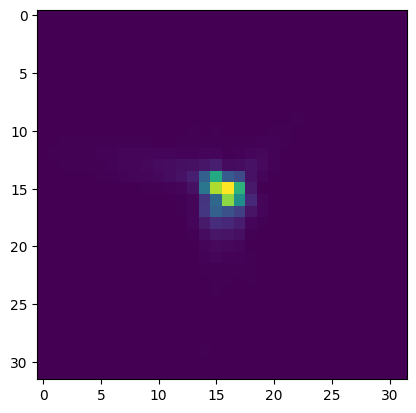

In [4]:
plt.imshow(fgs_data.values[0].reshape((32, 32)))

# Check whether CDS needs to be applied
```
Every even signal: Charge = Baseline + Noise
Every odd signal:  Charge = Astrophysical_Signal + Baseline + Noise 
CDS: Charge = Even - Odd = Astrophysical_Signal
```
The idea is if signal brightness follows zigzag shape - CDS was not applied to given data and it needs to be applied to all AIRS data.

Signal shape: (11250, 11392)

--- CDS DETECTION ANALYSIS ---
Mean brightness (even frames - reset): 5156169
Mean brightness (odd frames - signal): 13415253
Ratio (odd/even): 2.602


/tmp/ipykernel_9906/3949458668.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([brightness_even[:1000], brightness_odd[:1000]],


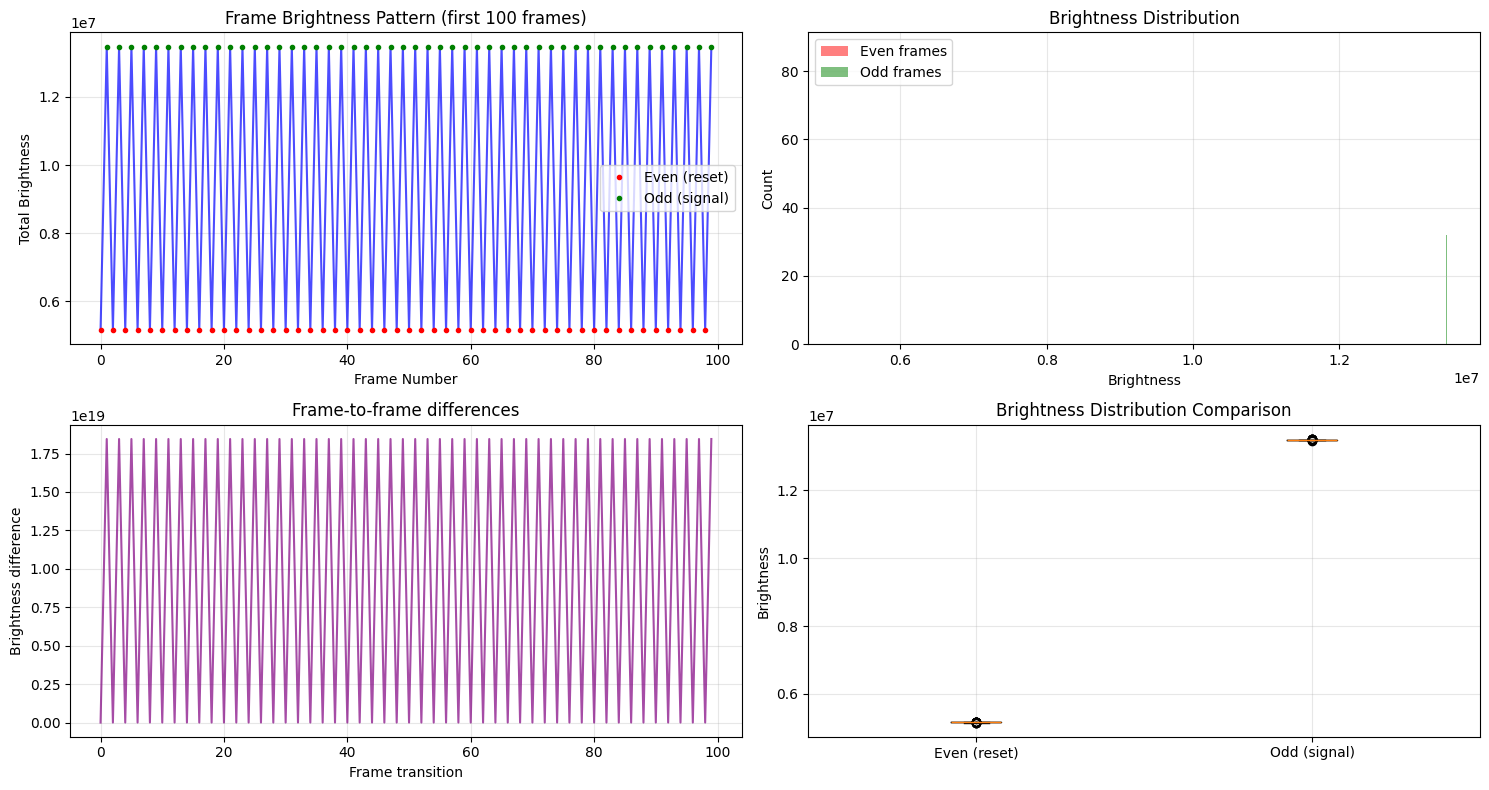

VERDICT: CDS NOT APPLIED - Clear signal/reset pattern detected!
Odd frames significantly brighter → raw detector data


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def check_cds_applied(planet_id):
    
    signal_path = f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/AIRS-CH0_signal_0.parquet'
    
    signal = pd.read_parquet(signal_path).values
    print(f"Signal shape: {signal.shape}")
    
    frame_brightness = signal.sum(axis=1)
    
    brightness_even = frame_brightness[::2]
    brightness_odd = frame_brightness[1::2]
    
    mean_even = brightness_even.mean()
    mean_odd = brightness_odd.mean()
    ratio = mean_odd / mean_even
    
    print(f"\n--- CDS DETECTION ANALYSIS ---")
    print(f"Mean brightness (even frames - reset): {mean_even:.0f}")
    print(f"Mean brightness (odd frames - signal): {mean_odd:.0f}")
    print(f"Ratio (odd/even): {ratio:.3f}")
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(frame_brightness[:100], 'b-', alpha=0.7)
    plt.plot(range(0, 100, 2), brightness_even[:50], 'ro', markersize=3, label='Even (reset)')
    plt.plot(range(1, 100, 2), brightness_odd[:50], 'go', markersize=3, label='Odd (signal)')
    plt.title('Frame Brightness Pattern (first 100 frames)')
    plt.xlabel('Frame Number')
    plt.ylabel('Total Brightness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.hist(brightness_even[:500], bins=50, alpha=0.5, label='Even frames', color='red')
    plt.hist(brightness_odd[:500], bins=50, alpha=0.5, label='Odd frames', color='green')
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    diff_pattern = frame_brightness[1:] - frame_brightness[:-1]
    plt.plot(diff_pattern[:100], 'purple', alpha=0.7)
    plt.title('Frame-to-frame differences')
    plt.xlabel('Frame transition')
    plt.ylabel('Brightness difference')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.boxplot([brightness_even[:1000], brightness_odd[:1000]], 
                labels=['Even (reset)', 'Odd (signal)'])
    plt.title('Brightness Distribution Comparison')
    plt.ylabel('Brightness')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if ratio > 1.5:
        print("VERDICT: CDS NOT APPLIED - Clear signal/reset pattern detected!")
        print("Odd frames significantly brighter → raw detector data")
    elif ratio > 1.1:
        print("VERDICT: UNCLEAR - Moderate difference, possible partial processing")
    else:
        print("VERDICT: CDS LIKELY APPLIED - No systematic brightness difference")
        print("Similar brightness levels → data already processed")
        
    return {
        'mean_even': mean_even,
        'mean_odd': mean_odd,
        'ratio': ratio,
        'cds_applied': ratio < 1.1
    }

results = check_cds_applied(34983)

# Check for AIRS and FGS temporal alignment
Done in order to further use the data in cross-attention.

--- TEMPORAL ALIGNMENT CHECK FOR PLANET 34983 ---
AIRS clean time range: 0.000028 - 7.498722 hours
FGS clean time range: 0.000028 - 7.499944 hours
AIRS total valid frames: 11250
FGS total valid frames: 135000
AIRS median cadence: 0.000028 hours between frames
FGS median cadence: 0.000028 hours between frames

Overlap window: 0.000028 - 7.498722 hours
Overlap duration: 7.498694 hours
AIRS frames in overlap: 11250/11250
FGS frames in overlap: 134978/135000


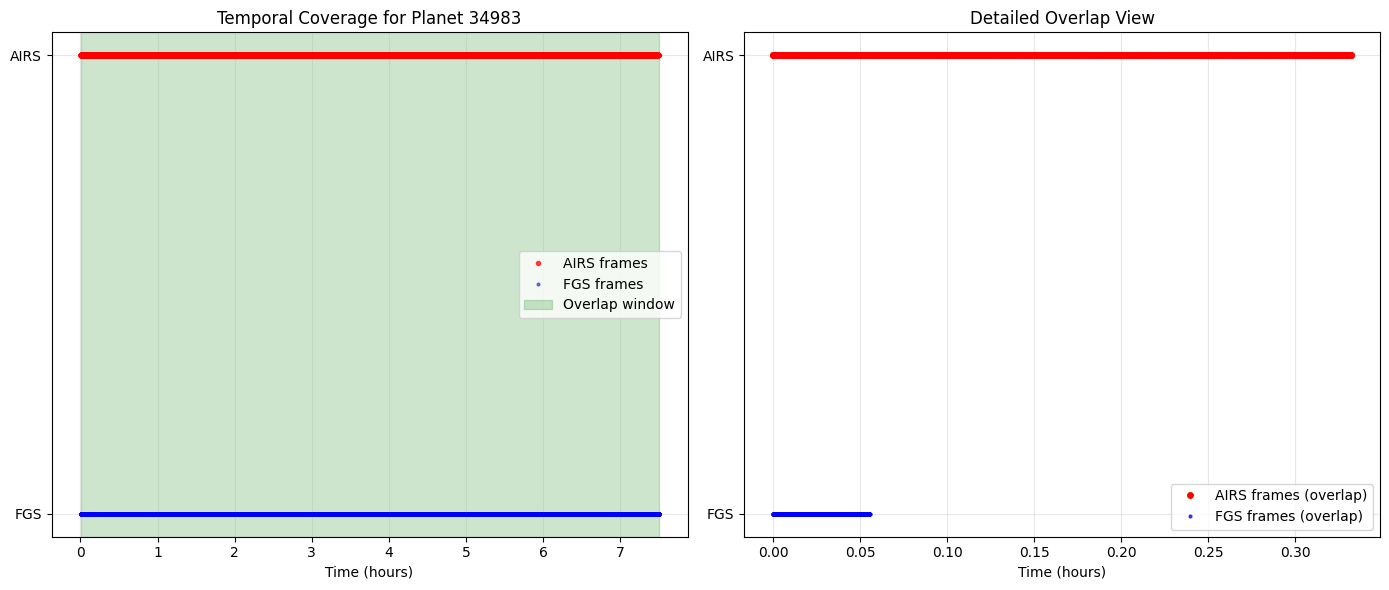


Alignment quality (overlap fraction): 1.000


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def check_temporal_alignment(planet_id, axis_info_parquet_path):
    print(f"--- TEMPORAL ALIGNMENT CHECK FOR PLANET {planet_id} ---")
    
    axis_info = pd.read_parquet(axis_info_parquet_path)
    
    airs_times = axis_info['AIRS-CH0-axis0-h'].values
    airs_times_clean = airs_times[~np.isnan(airs_times)]
    
    fgs_times = axis_info['FGS1-axis0-h'].values
    fgs_times_clean = fgs_times[~np.isnan(fgs_times)]
    
    if len(airs_times_clean) == 0 or len(fgs_times_clean) == 0:
        print("ERROR: One of the instruments has no valid timestamps!")
        return None
    
    print(f"AIRS clean time range: {airs_times_clean[0]:.6f} - {airs_times_clean[-1]:.6f} hours")
    print(f"FGS clean time range: {fgs_times_clean[0]:.6f} - {fgs_times_clean[-1]:.6f} hours")
    print(f"AIRS total valid frames: {len(airs_times_clean)}")
    print(f"FGS total valid frames: {len(fgs_times_clean)}")
    
    airs_cadence = np.median(np.diff(airs_times_clean))
    fgs_cadence = np.median(np.diff(fgs_times_clean))
    print(f"AIRS median cadence: {airs_cadence:.6f} hours between frames")
    print(f"FGS median cadence: {fgs_cadence:.6f} hours between frames")
    
    overlap_start = max(airs_times_clean[0], fgs_times_clean[0])
    overlap_end = min(airs_times_clean[-1], fgs_times_clean[-1])
    overlap_duration = overlap_end - overlap_start
    
    if overlap_duration <= 0:
        print("CRITICAL: NO OVERLAP BETWEEN AIRS and FGS!")
        return None
    
    print(f"\nOverlap window: {overlap_start:.6f} - {overlap_end:.6f} hours")
    print(f"Overlap duration: {overlap_duration:.6f} hours")
    
    airs_in_overlap = (airs_times_clean >= overlap_start) & (airs_times_clean <= overlap_end)
    fgs_in_overlap = (fgs_times_clean >= overlap_start) & (fgs_times_clean <= overlap_end)
    
    airs_count = np.sum(airs_in_overlap)
    fgs_count = np.sum(fgs_in_overlap)
    
    print(f"AIRS frames in overlap: {airs_count}/{len(airs_times_clean)}")
    print(f"FGS frames in overlap: {fgs_count}/{len(fgs_times_clean)}")
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(airs_times_clean, np.ones_like(airs_times_clean), 'ro', markersize=3, alpha=0.7, label='AIRS frames')
    plt.plot(fgs_times_clean, np.ones_like(fgs_times_clean)*0.9, 'bo', markersize=2, alpha=0.5, label='FGS frames')
    plt.axvspan(overlap_start, overlap_end, color='green', alpha=0.2, label='Overlap window')
    plt.xlabel('Time (hours)')
    plt.yticks([0.9, 1], ['FGS', 'AIRS'])
    plt.title(f'Temporal Coverage for Planet {planet_id}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    air_zoom = airs_times_clean[airs_in_overlap]
    fgs_zoom = fgs_times_clean[fgs_in_overlap]
    
    n_air = len(air_zoom)
    n_fgs = len(fgs_zoom)
    air_plot = air_zoom[:min(n_air, 500)]
    fgs_plot = fgs_zoom[:min(n_fgs, 1000)]
    
    plt.plot(air_plot, np.ones_like(air_plot), 'ro', markersize=4, label='AIRS frames (overlap)')
    plt.plot(fgs_plot, np.ones_like(fgs_plot)*0.9, 'bo', markersize=2, alpha=0.7, label='FGS frames (overlap)')
    plt.xlabel('Time (hours)')
    plt.yticks([0.9, 1], ['FGS', 'AIRS'])
    plt.title('Detailed Overlap View')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    alignment_score = min(airs_count / len(airs_times_clean), fgs_count / len(fgs_times_clean))
    
    print(f"\nAlignment quality (overlap fraction): {alignment_score:.3f}")
    
    return {
        'airs_time_range': (airs_times_clean[0], airs_times_clean[-1]),
        'fgs_time_range': (fgs_times_clean[0], fgs_times_clean[-1]),
        'airs_cadence': airs_cadence,
        'fgs_cadence': fgs_cadence,
        'overlap_start': overlap_start,
        'overlap_end': overlap_end,
        'overlap_duration': overlap_duration,
        'airs_frames_in_overlap': airs_count,
        'fgs_frames_in_overlap': fgs_count,
        'alignment_quality': alignment_score
    }


alignment_result = check_temporal_alignment(
    planet_id=34983,
    axis_info_parquet_path='/kaggle/input/ariel-data-challenge-2025/axis_info.parquet'
)


# Dataset Class

In [7]:
import pandas as pd
pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet').head()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.000028,4.078463,0.1,0.000028
1,0.000056,4.074023,4.5,0.000056
2,0.001361,4.069568,0.1,0.000139
3,0.001389,4.065100,4.5,0.000167
4,0.002694,4.060618,0.1,0.000250


In [8]:
!pip install pytorch-lightning
!pip install astropy


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [9]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import os

class ArielDataset(Dataset):
    """
    Hybrid dataset for Ariel data with cached FGS preprocessing.
    
    Processes AIRS data live while loading preprocessed FGS data from cache
    to optimize training speed and memory usage.
    """
    
    def __init__(self, root_path, train_csv, star_info_csv, wavelengths_csv, 
                 axis_info_path, fgs_cache_file=None, verbose=True):

        self.root_path = root_path
        self.train_gt = pd.read_csv(train_csv)
        self.star_info = pd.read_csv(star_info_csv)
        self.wavelengths = pd.read_csv(wavelengths_csv).values.flatten()
        self.axis_info = pd.read_parquet(axis_info_path)
        self.verbose = verbose
        
        self.wl_cols = [col for col in self.train_gt.columns if col.startswith('wl_')]
        self.planet_ids = self.train_gt['planet_id'].values
        
        # Load FGS cache
        self.fgs_cache = {}
        if fgs_cache_file and os.path.exists(fgs_cache_file):
            self.fgs_cache = torch.load(fgs_cache_file, map_location='cpu', weights_only=False)
            if self.verbose:
                print(f'Loaded FGS cache for {len(self.fgs_cache)} planets')
        else:
            if self.verbose:
                print('No FGS cache found - falling back to live processing')
        
        if self.verbose:
            print(f'Dataset initialized with {len(self.planet_ids)} planets')
            cache_coverage = len(self.fgs_cache) / len(self.planet_ids) * 100
            print(f'FGS cache coverage: {cache_coverage:.1f}%')
    
    def __len__(self):
        return len(self.planet_ids)
    
    def __getitem__(self, idx):
        planet_id = self.planet_ids[idx]
        
        try:
            # Load ground truth spectrum
            gt_row = self.train_gt[self.train_gt['planet_id'] == planet_id]
            target_spectrum = gt_row[self.wl_cols].values[0].astype(np.float32)
            
            # Load stellar parameters
            star_row = self.star_info[self.star_info['planet_id'] == planet_id]
            star_params = star_row[['Rs', 'Ms', 'Ts', 'Mp', 'e', 'P', 'sma', 'i']].values[0].astype(np.float32)
            
            # Process AIRS data (live processing)
            signal_path = f"{self.root_path}/{planet_id}/AIRS-CH0_signal_0.parquet"
            calibration_path = f"{self.root_path}/{planet_id}/AIRS-CH0_calibration_0"
            airs_calibrated, airs_times = self.process_airs_data(signal_path, calibration_path)
            
            # Load FGS data (cached or live fallback)
            fgs_synced = self._load_fgs_data(planet_id, airs_times)
            
            return {
                'planet_id': planet_id,
                'airs_spectra': torch.FloatTensor(airs_calibrated),
                'fgs_curve': torch.FloatTensor(fgs_synced),
                'star_params': torch.FloatTensor(star_params),
                'wavelengths': torch.FloatTensor(self.wavelengths),
                'target_spectrum': torch.FloatTensor(target_spectrum)
            }
            
        except Exception as e:
            if self.verbose:
                print(f'Error loading planet {planet_id}: {e}')
            return None
    
    def _load_fgs_data(self, planet_id, airs_times):
        """Load FGS data from cache or process live."""
        if planet_id in self.fgs_cache:
            # Fast path: load from cache
            return self.fgs_cache[planet_id].numpy()
        else:
            # Slow path: live processing
            if self.verbose:
                print(f'Planet {planet_id} not in cache - processing live')
            fgs_path = f"{self.root_path}/{planet_id}/FGS1_signal_0.parquet"
            return self.process_fgs_data(fgs_path, airs_times)
    
    def process_airs_data(self, signal_path, calibration_path):
        """Process AIRS data with CDS and calibration."""
        from astropy.stats import sigma_clip
        
        if not os.path.exists(signal_path):
            raise FileNotFoundError(f"AIRS signal file not found: {signal_path}")
        if not os.path.exists(calibration_path):
            raise FileNotFoundError(f"AIRS calibration path not found: {calibration_path}")
        
        signal = pd.read_parquet(signal_path).values.astype(np.float64)
        original_frames = signal.shape[0]
        
        dark = pd.read_parquet(os.path.join(calibration_path, 'dark.parquet')).values
        dead = pd.read_parquet(os.path.join(calibration_path, 'dead.parquet')).values
        flat = pd.read_parquet(os.path.join(calibration_path, 'flat.parquet')).values
        
        rows, cols = 32, 356
        signal_3d = signal.reshape(original_frames, rows, cols)
        dark_3d = dark.reshape(rows, cols)
        dead_3d = dead.reshape(rows, cols)
        flat_3d = flat.reshape(rows, cols)
        
        # Hot pixel detection
        hot_mask = sigma_clip(dark_3d, sigma=5, maxiters=5).mask
        full_mask = np.logical_or(dead_3d, hot_mask)
        signal_masked = np.ma.masked_array(signal_3d, mask=np.tile(full_mask, (original_frames, 1, 1)))
        
        # CDS processing
        if signal_masked.shape[0] % 2 != 0:
            signal_masked = signal_masked[:-1]
        cds_signal = signal_masked[1::2] - signal_masked[::2]
        
        # Flat field correction
        n_cds = cds_signal.shape[0]
        safe_flat = np.where(flat_3d < 0.1, 1.0, flat_3d)
        cds_calibrated = cds_signal / np.tile(safe_flat, (n_cds, 1, 1))
        
        # Temporal axis processing
        time_axis_raw = self.axis_info['AIRS-CH0-axis0-h'][:original_frames].values
        time_clean = time_axis_raw[~np.isnan(time_axis_raw)]
        if len(time_clean) % 2 != 0:
            time_clean = time_clean[:-1]
        time_cds = (time_clean[1::2] + time_clean[::2]) / 2
        
        # Ensure consistent lengths
        min_len = min(len(time_cds), cds_calibrated.shape[0])
        time_cds = time_cds[:min_len]
        cds_calibrated = cds_calibrated[:min_len]
        
        return cds_calibrated.filled(0), time_cds
    
    def process_fgs_data(self, fgs_path, airs_times):
        """Process FGS data with CDS and temporal synchronization."""
        if not os.path.exists(fgs_path):
            raise FileNotFoundError(f"FGS file not found: {fgs_path}")
        
        fgs_raw = pd.read_parquet(fgs_path).values
        n_frames = fgs_raw.shape[0]
        fgs_3d = fgs_raw.reshape(n_frames, 32, 32)
        
        # Apply CDS
        if fgs_3d.shape[0] % 2 != 0:
            fgs_3d = fgs_3d[:-1, :, :]
        fgs_cds = fgs_3d[1::2, :, :] - fgs_3d[::2, :, :]
        
        # Spatial summing for photometry
        fgs_photometry = fgs_cds.sum(axis=(1, 2))
        
        # FGS temporal axis processing
        fgs_times_raw = self.axis_info['FGS1-axis0-h'].values
        fgs_times_clean = fgs_times_raw[~np.isnan(fgs_times_raw)]
        if len(fgs_times_clean) % 2 != 0:
            fgs_times_clean = fgs_times_clean[:-1]
        fgs_times_cds = (fgs_times_clean[1::2] + fgs_times_clean[::2]) / 2
        
        # Ensure consistent lengths
        min_fgs_length = min(len(fgs_times_cds), len(fgs_photometry))
        fgs_times_cds = fgs_times_cds[:min_fgs_length]
        fgs_photometry = fgs_photometry[:min_fgs_length]
        
        # Interpolate to AIRS temporal grid
        fgs_synced = np.interp(airs_times, fgs_times_cds, fgs_photometry)
        
        return fgs_synced


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


# Pytorch Lightning Datamodule and Model
### Encoding and Utility Functions

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

class AdaptiveSpectralPositionalEncoding(nn.Module):
    """Physics-based positional encoding für spektrale Wellenlängen"""
    def __init__(self, d_model, learnable_scale=True):
        super().__init__()
        if learnable_scale:
            self.wavelength_scale = nn.Parameter(torch.ones(1))
        else:
            self.register_buffer('wavelength_scale', torch.ones(1))
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.register_buffer('div_term', div_term)

    def forward(self, x, wavelengths):
        batch, seq, d_model = x.shape
        wl = wavelengths.to(x.device) * self.wavelength_scale
        pe = torch.zeros(seq, d_model, device=x.device, dtype=x.dtype)
        position = wl.unsqueeze(1)
        pe[:, 0::2] = torch.sin(position * self.div_term)
        cos_terms = min(d_model // 2, len(self.div_term))
        pe[:, 1::2][:, :cos_terms] = torch.cos(position * self.div_term[:cos_terms])
        pe = pe.unsqueeze(0).expand(batch, -1, -1)
        return x + pe

class PositionalEncoding(nn.Module):
    """Standard temporal positional encoding"""
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class AttentionPooling(nn.Module):
    """Learnable temporal pooling statt brutaler stride"""
    def __init__(self, channels, pool_size=16):
        super().__init__()
        self.pool_size = pool_size
        mid_ch = max(channels // 4, 1)
        self.attn = nn.Sequential(
            nn.Conv1d(channels, mid_ch, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(mid_ch, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch, channels, time = x.shape
        if time < self.pool_size:
            return x
        trimmed_len = (time // self.pool_size) * self.pool_size
        x_trimmed = x[:, :, :trimmed_len]
        x_reshaped = x_trimmed.view(batch, channels, trimmed_len // self.pool_size, self.pool_size)
        weights = self.attn(x_trimmed)
        weights_reshaped = weights.view(batch, 1, trimmed_len // self.pool_size, self.pool_size)
        weights_norm = F.softmax(weights_reshaped, dim=-1)
        pooled = (x_reshaped * weights_norm).sum(dim=-1)
        return pooled

class Conditioning(nn.Module):
    """Physical parameter conditioning mit gating"""
    def __init__(self, dim):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Sigmoid()
        )
    
    def forward(self, x, cond):
        gate = self.gate(cond).unsqueeze(1)
        return x + gate * cond.unsqueeze(1)

class TransformerBlock(nn.Module):
    """Multi-modal transformer block mit cross-attention"""
    def __init__(self, d_model=256, n_heads=8, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.conditioning = Conditioning(d_model)
    
    def forward(self, src, cross, cond=None):
        # Self-attention
        src2, _ = self.self_attn(src, src, src)
        src = self.norm1(src + self.dropout1(src2))
        
        # Cross-attention mit FGS
        src2, attn_weights = self.cross_attn(src, cross, cross)
        src = self.norm2(src + self.dropout2(src2))
        
        # Physical conditioning
        if cond is not None:
            src = self.conditioning(src, cond)
        
        # Feed-forward
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = self.norm3(src + self.dropout3(src2))
        return src, attn_weights


### Transformer

In [11]:
class ArielTransformer(nn.Module):
    """Physics-informed multi-modal transformer für Ariel spectroscopy"""
    def __init__(self, airs_channels=356, d_model=256, n_heads=8, n_layers=4, 
                 dropout=0.1, output_wavelengths=283):
        super().__init__()
        self.d_model = d_model
        self.airs_channels = airs_channels
        
        # Temporal pooling für beide modalities
        self.temporal_pool_airs = AttentionPooling(airs_channels, pool_size=16)
        self.temporal_pool_fgs = AttentionPooling(1, pool_size=16)
        
        # Embedding projections
        self.airs_proj = nn.Sequential(
            nn.Linear(airs_channels, d_model),
            nn.LayerNorm(d_model)
        )
        self.fgs_proj = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model)
        )
        self.cond_proj = nn.Sequential(
            nn.Linear(8, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model)
        )
        
        # Positional encodings
        self.spectral_pe = AdaptiveSpectralPositionalEncoding(d_model, learnable_scale=True)
        self.pos_encoder = PositionalEncoding(d_model, max_len=10000)
        
        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dim_feedforward=4*d_model, dropout=dropout) 
            for _ in range(n_layers)
        ])
        
        # Output head
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, output_wavelengths),
            nn.Sigmoid()
        )
    
    def forward(self, airs, fgs, star_params):
        batch, time = airs.shape[0], airs.shape[1]
        
        # Spatial averaging für AIRS
        airs_spatial = airs.mean(dim=2)  # [batch, time, 356]
        
        # Temporal pooling
        airs_temporal = airs_spatial.permute(0, 2, 1)  # [batch, 356, time]
        airs_downsampled = self.temporal_pool_airs(airs_temporal)
        airs_downsampled = airs_downsampled.permute(0, 2, 1)
        
        # AIRS embedding mit spectral encoding
        airs_emb = self.airs_proj(airs_downsampled)
        detector_wavelengths = torch.linspace(1.633, 4.078, airs_emb.size(1), device=airs_emb.device)
        airs_emb = self.spectral_pe(airs_emb, detector_wavelengths)
        
        # FGS processing
        fgs_temporal = fgs.unsqueeze(1)
        fgs_downsampled = self.temporal_pool_fgs(fgs_temporal)
        fgs_downsampled = fgs_downsampled.permute(0, 2, 1)
        
        fgs_emb = self.fgs_proj(fgs_downsampled)
        fgs_emb = self.pos_encoder(fgs_emb)
        
        # Physical conditioning
        cond_emb = self.cond_proj(star_params)
        
        # Transformer processing
        x = airs_emb
        attn_list = []
        for layer in self.layers:
            x, attn = layer(x, fgs_emb, cond_emb)
            attn_list.append(attn)
        
        # Output prediction
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        out = self.output_head(x)
        
        return {'spectrum': out, 'attentions': attn_list}


### Data Module

In [12]:
class ArielDataModule(pl.LightningDataModule):
    """
    Lightning DataModule for Ariel dataset with optimized data loading.
    
    Supports cached FGS data and configurable batch sizes for training
    and validation with memory-aware settings.
    """
    
    def __init__(self, data_paths, batch_size=4, 
                 train_split=0.8, num_workers=2):
        
        super().__init__()
        self.data_paths = data_paths
        self.batch_size = batch_size
        self.train_split = train_split
        self.num_workers = num_workers
        
    def setup(self, stage=None):
        full_dataset = ArielDataset(
            root_path=self.data_paths['root_path'],
            train_csv=self.data_paths['train_csv'],
            star_info_csv=self.data_paths['star_info_csv'],
            wavelengths_csv=self.data_paths['wavelengths_csv'],
            axis_info_path=self.data_paths['axis_info_path'],
            fgs_cache_file=self.data_paths['fgs_cache_file'],
            verbose=True
        )
        
        # Train/validation split
        total_size = len(full_dataset)
        train_size = int(self.train_split * total_size)
        val_size = total_size - train_size
        
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )
        
        print(f'Data split: {train_size} training, {val_size} validation samples')
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=True,
            pin_memory=True,
            collate_fn=self._collate_fn,
            drop_last=True
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True,
            pin_memory=True,
            collate_fn=self._collate_fn
        )
    
    def _collate_fn(self, batch):
        """Custom collate function with error handling."""
        valid_batch = [item for item in batch if item is not None]
        
        if len(valid_batch) == 0:
            return None
        
        collated = {}
        for key in valid_batch[0].keys():
            if key == 'planet_id':
                collated[key] = [item[key] for item in valid_batch]
            else:
                try:
                    collated[key] = torch.stack([item[key] for item in valid_batch])
                except RuntimeError as e:
                    print(f'Error stacking {key}: {e}')
                    # Fallback: use first valid sample
                    collated[key] = valid_batch[0][key].unsqueeze(0)
        
        return collated


### Model Module

In [13]:
class ArielLightningModule(pl.LightningModule):
    """Complete Lightning Module für physics-informed Ariel Transformer"""
    def __init__(self, airs_channels=356, d_model=256, n_heads=8, n_layers=4, 
                 dropout=0.1, output_wavelengths=283, lr=1e-4, weight_decay=1e-5):
        super().__init__()
        self.save_hyperparameters()
        
        # Model und Loss
        self.model = ArielTransformer(
            airs_channels=airs_channels,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            dropout=dropout,
            output_wavelengths=output_wavelengths
        )
        
        self.lr = lr
        self.weight_decay = weight_decay
        
        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
    
    def forward(self, airs, fgs, star_params):
        """Forward pass - Lightning managed device handling!"""
        return self.model(airs, fgs, star_params)
    
    def training_step(self, batch, batch_idx):
        """Training step - alles automatisch auf GPU!"""
        if batch is None:
            return None
        
        # Forward pass
        outputs = self.forward(
            batch['airs_spectra'],
            batch['fgs_curve'],
            batch['star_params']
        )
        
        # Loss computation
        spectrum_pred = outputs['spectrum']
        target_spectrum = batch['target_spectrum']
        loss = F.mse_loss(spectrum_pred, target_spectrum)
        
        # Logging für TensorBoard/WandB
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('learning_rate', self.optimizers().param_groups[0]['lr'], on_step=True)
        
        # Store für epoch end
        self.train_losses.append(loss.detach())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Validation step - auch GPU managed"""
        if batch is None:
            return None
        
        # Forward pass
        outputs = self.forward(
            batch['airs_spectra'],
            batch['fgs_curve'],
            batch['star_params']
        )
        
        # Loss computation
        spectrum_pred = outputs['spectrum']
        target_spectrum = batch['target_spectrum']
        val_loss = F.mse_loss(spectrum_pred, target_spectrum)
        
        # Additional metrics
        mae = F.l1_loss(spectrum_pred, target_spectrum)
        
        # Logging
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)
        self.log('val_mae', mae, prog_bar=True, on_epoch=True)
        
        self.val_losses.append(val_loss.detach())
        
        return val_loss
        
    def memory_cleanup(self):
        import gc
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        try:
            import torch_xla.core.xla_model as xm
            xm.mark_step() 
        except ImportError:
            pass
    
    def on_train_epoch_end(self):
        """Called am Ende jeder training epoch"""
        if len(self.train_losses) > 0:
            avg_train_loss = torch.stack(self.train_losses).mean()
            self.log('train_loss_epoch', avg_train_loss)
            self.train_losses.clear()
            self.memory_cleanup()
    
    def on_validation_epoch_end(self):
        """Called am Ende jeder validation epoch"""
        if len(self.val_losses) > 0:
            avg_val_loss = torch.stack(self.val_losses).mean()
            self.log('val_loss_epoch', avg_val_loss)
            self.val_losses.clear()
    
    def configure_optimizers(self):
        """Optimizer configuration - Lightning standard"""
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler (optional)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=1e-6
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }


In [14]:
def train_ariel_lightning(data_paths, max_epochs=50, batch_size=8, num_workers=16, accumulate_grad_batches=1, gpus=1):
    """Complete Lightning training setup"""
    
    # DataModule setup
    data_module = ArielDataModule(
        data_paths,
        batch_size=batch_size,
        num_workers=num_workers
    )
    
    # Lightning Module
    model = ArielLightningModule(
        d_model=256,
        n_heads=8,
        n_layers=4,
        lr=1e-4,
        weight_decay=1e-5
    )
    
    # Lightning Trainer - GPU handling automatic!
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='tpu',
        devices=gpus,
        precision='bf16-true',
        log_every_n_steps=10,
        check_val_every_n_epoch=2,
        limit_val_batches=0.5,
        accumulate_grad_batches=accumulate_grad_batches,
        
        default_root_dir='./ariel_training_logs',
        enable_model_summary=True,
    )
    
    # Training starten - Lightning macht alles!
    trainer.fit(model, data_module)
    
    return model, trainer

In [ ]:
data_paths = {
    'root_path': '/kaggle/input/ariel-data-challenge-2025/train',
    'train_csv': '/kaggle/input/ariel-data-challenge-2025/train.csv',
    'star_info_csv': '/kaggle/input/ariel-data-challenge-2025/train_star_info.csv',
    'wavelengths_csv': '/kaggle/input/ariel-data-challenge-2025/wavelengths.csv',
    'axis_info_path': '/kaggle/input/ariel-data-challenge-2025/axis_info.parquet',
    'fgs_cache_file': '/kaggle/input/fgs-processed/fgs_all_planets_preprocessed.pt',
}

model, trainer = train_ariel_lightning(
    data_paths=data_paths,
    max_epochs=10,
    batch_size=16,
    num_workers=14,
    accumulate_grad_batches=1,
    gpus=1
)

E0000 00:00:1754428071.046158    9906 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:232
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: True, using: 1 TPU cores
HPU available: False, using: 0 HPUs
E0000 00:00:1754428075.247181    9906 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Loaded FGS cache for 1100 planets
Dataset initialized with 1100 planets
FGS cache coverage: 100.0%
Data split: 880 training, 220 validation samples



  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ArielTransformer | 4.7 M  | train
---------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.949    Total estimated model params size (MB)
105       Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 55/55 [07:35<00:00,  0.12it/s, v_num=2, train_loss_step=0.150, train_loss_epoch=0.209] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 55/55 [07:51<00:00,  0.12it/s, v_num=2, train_loss_step=0.0762, train_loss_epoch=0.133, val_loss=0.148, val_mae=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 55/55 [08:06<00:00,  0.11it/s, v_num=2, train_loss_step=0.0522, train_loss_epoch=0.0674, val_loss=0.0684, val_mae=0.227] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 55/55 [08:17<00:00,  0.11it/s, v_num=2, train_loss_step=0.0479, train_loss_epoch=0.0491, val_loss=0.0442, val_mae=0.178] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9:  53%|█████▎    | 29/55 [05:09<04:37,  0.09it/s, v_num=2, train_loss_step=0.0466, train_loss_epoch=0.0474, val_loss=0.0398, val_mae=0.167] 

In [ ]:
model